In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os.path

In [44]:
filename = '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/paper/images/ak_0.6_m8_1543-47/sum.dat'
model = np.genfromtxt(
    # Kerr 0.9
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.9829e+38/alpha_0.64902/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8954e+38/alpha_0.88938/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8485e+38/alpha_0.99979/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7979e+38/alpha_1.27575/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7347e+38/alpha_1.4379/sum.dat',
    # Kerr 0.9, Tph=8000
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_9.8653e+37/alpha_0.99589/sum.dat',
    # Kerr 0.6
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_2.5947e+38/alpha_0.82624/sum.dat',
    filename,
    names=True
)
obsB = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_B.txt',
    names=['t','mB'],
    delimiter=', '
)
obsV = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_Vall.txt',
    names=['t','mV'],
    delimiter=', '
)

obsV_err = 0.06

model['t'] -= 4.88
obsB['t'] -= 52445.5
obsV['t'] -= 52445.5
cut_t = -3

AV = 1.6
AB = 1.324 * 1.6

obsV['mV'] -= AV
obsB['mB'] -= AB

<IPython.core.display.Javascript object>


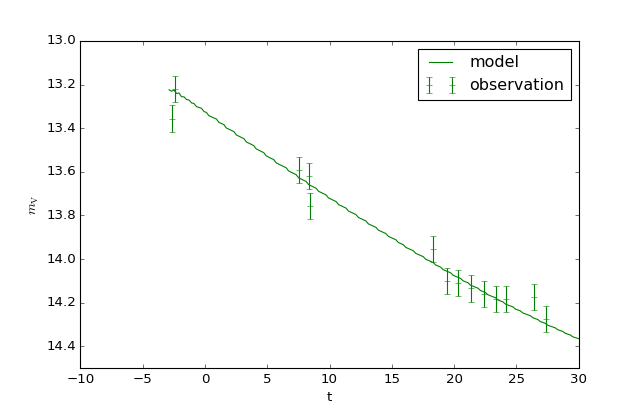

In [48]:
mV_cold = -2.5 * np.log10( 1 - (model['Rhot2Rout']-1e-9)**2. ) + 10000
mB_cold = -2.5 * np.log10( 1 - (model['Rhot2Rout']-1e-9)**2. ) + 10000

backgroundV = obsV['mV'][ obsV['t'] < -50 ].mean()
# backgroundB = obsB['mB'][ obsB['t'] < -50 ].mean()
# http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/469/807/lmxb
backgroundB = 17.5 - AB

mV_sum = -2.5 * np.log10(
    + np.power(10., -0.4 * model['mV'])
    + np.power(10., -0.4 * mV_cold)
    + np.power(10., -0.4 * backgroundV)
)
mB_sum = -2.5 * np.log10(
    + np.power(10., -0.4 * model['mB'])
    + np.power(10., -0.4 * mB_cold)
    + np.power(10., -0.4 * backgroundB)
)

plt.gca().invert_yaxis()
plt.xlabel('t')
plt.ylabel(r'$m_\mathrm{V}$')
plt.ylim([14.5,13.])
plt.xlim([-10,30])
plt.plot( model['t'][ model['t'] > cut_t ], mV_sum[ model['t'] > cut_t ], 'g-', label='model' )
plt.errorbar( obsV['t'], obsV['mV'], fmt='g+', yerr=obsV_err, label='observation' )
#plt.plot( model['t'][ model['t'] > cut_t ], mB_sum[ model['t'] > cut_t ], 'b-' )
#plt.plot( obsB['t'], obsB['mB'], 'b+' )
plt.legend(loc='best')

plt.savefig( os.path.join( os.path.dirname(filename), 'opt.eps') )